<a href="https://colab.research.google.com/github/RasyaAkbar/learning-py-torch/blob/main/02.%20PyTorch%20Workflow%20%2B%20Exercise%20(in%20T4%20GPU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
from torch import nn # nn contains all of building blocks of neural networks from torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## 1. Data (preparing and loading)

Machine learning is a game in two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

we'll use linear regression formula to make straight line with **known parameters**



In [3]:
# create *known* parameter
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
# Note: X capital represent matrix or tensor, x lowercase represent vector
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias # Linear regression

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

## Splitting data into training and test sets

In [4]:
# Create a train/test split
train_split = int(0.8 * len(X)) # split 80%
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_test), len(X_train)

(10, 40)

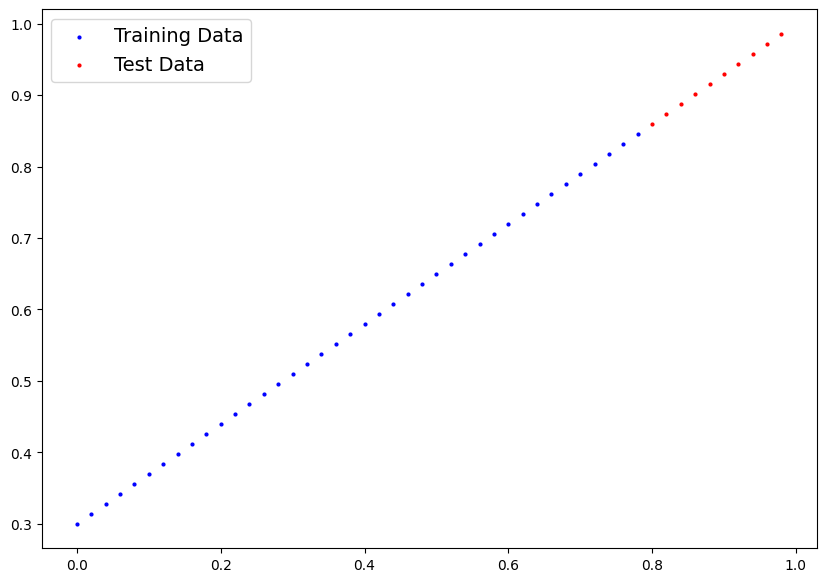

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))

  # plot data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

  # plot test data in red
  plt.scatter(test_data, test_labels, c="r", s=4, label="Test Data")

  if predictions is not None:
    # plot prediction if exist
    plt.scatter(test_data, predictions, c="g", s=4, label="Predictions")

  plt.legend(prop={"size": 14})

plot_predictions()

## 2. Build model
Our first PyTorch model

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we usd to create the data)

How does it do so ?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

The code below will trigger the two algorithms for us (basically we write high-level code to trigger them, and PyTorch will do it for us)

In [34]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    # initialize params with random value (docs reference: torch.nn.Parameter)
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True, # keep track of gradients and updates them through combination of gradient descent and backpropagation (the function behind the scene called torch.autograd)
                                            dtype=torch.float # torch default is float32
                                            ))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True, # keep track of gradients and updates them through combination of gradient descent and backpropagation (the function behind the scene called torch.autograd)
                                         dtype=torch.float # torch default is float32
                                         ))

  # forward method to define the computation in the model
  # forward method adjust weight and bias to match our known parameter w=0.7, b=0.3
  # base class for all nn modules, if you subclass it, you should overwrite forward() (docs reference: torch.nn.Module forward() method)
  def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" is input data
    return self.weights * x + self.bias # Linear regression

## PyTorch model building essentials


*   torch.nn - 	Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).
*   torch.nn.Parameter - Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".
*   torch.nn.Module - The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.


*   torch.optim - Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).
*   def forward() - All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (e.g. the linear regression formula above).




In [7]:
## Create random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out params (a parameter is a value that the model sets itself)
list(model_0.parameters()), model_0.state_dict()

([Parameter containing:
  tensor([0.3367], requires_grad=True),
  Parameter containing:
  tensor([0.1288], requires_grad=True)],
 OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))]))

In [8]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Make prediction using `torch.inference_mode()`
To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`. When we pass data through our model, it's going to run it through the ```forward()``` method








In [9]:
# context manager
with torch.inference_mode(): # inference mode turns off gradient tracking (similar to torch.no_grad(), but torch.inference_mode() i preferred)
  y_preds = model_0(X_test)

# with inference mode
print(y_preds)
# without inference mode
print(model_0(X_test))

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)


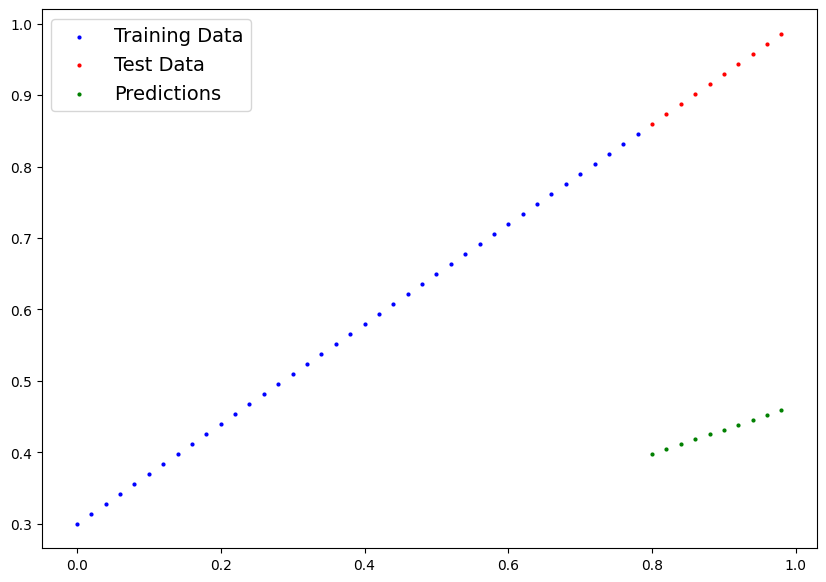

In [10]:
plot_predictions(predictions=y_preds)

## 3. Train Model

The whole idea of training is for a model to move from some *unknown* parameter (these may be random) to some *known* parameters.

basically turning poor representation to better representation of the data.

one way to measure how poor or how wrong your models prediction is to use loss function.

* Note : Loss function may also be called cost function or criterion in other areas

Things we need to train:
- **Loss function**: Measures how wrong your models predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test). Lower the better.
- **Optimizer**: Tells your model how to update its internal parameters to best lower the loss.

Mean absolute error (MAE, in PyTorch: torch.nn.L1Loss) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.

And we'll use SGD, torch.optim.SGD(params, lr) where:

* `params` is the target model parameters you'd like to optimize (e.g. the weights and bias values we randomly set before).
* `lr` is the learning rate you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a hyperparameter (because it's set by a machine learning engineer). Common starting values for the learning rate are 0.01, 0.001, 0.0001, however, these can also be adjusted over time (this is called learning rate scheduling).

Specifically in PyTorch we need:
* training loop
* testing loop

In [11]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01 # lr = learning rate = possibly the most important hyperparameter in ml
                            )

## Building a training loop (and a testing loop) in PyTorch

A couple of things we need in training loop:
0. Loop through the data
1. Forward propagation (also called forward pass) - this involves data moving through our model's `forward()` functions to make predictions on the data
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero gradient
4. Backpropagation (Loss backward) - move backwards through the network to calculate the gradients of each of the parameters of our model in respect to the loss
5. Optimizer step (Gradient descent) - use the optimizer to adjust our model's parameters to try improve the loss

In [12]:
torch.manual_seed(42) # optimizer step can be quite random depending on model prediction (y_pred)

# An epoch is one loop through the data (this is a hyperparameter)
epochs = 1000

# Track different values
epoch_count = []
loss_values = []
test_loss_values =[]


### Training (using training data)

#0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients


  #1. Forward propagation (also called forward pass)
  y_pred = model_0(X_train)

  #2. Calculate the loss (how wrong our model prediction is)(compare forward pass predictions to ground truth labels)(uses MAE)
  loss = loss_fn(y_pred, y_train)

  #3. Optimizer zero gradient
  optimizer.zero_grad() # start fresh each iteration

  #4. Backpropagation (Loss backward)
  loss.backward()

  #5. Optimizer step (Gradient descent)
  # Optimizer step optimize the parameter so that we can reach the point of convergence (where loss = 0 (great prediction))
  optimizer.step() # by default how optimizer changes will accumulate through the loop so we have to zero them above in step 3 for the next iteration of the loop
                  # may refer to the docs to understand why it accumulates

  ### Testing (using testing data)
  model_0.eval() # turns off different settings in the model not needing for testing
  with torch.inference_mode(): # turns off gradient tracking and couple more things behind the scenes
    #1. Forward propagation on test data
    test_pred = model_0(X_test)
    #2. Calculate the test loss (how wrong our model test prediction is)(compare forward pass predictions to ground truth labels)(uses MAE)
    test_loss = loss_fn(test_pred, y_test)
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [13]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

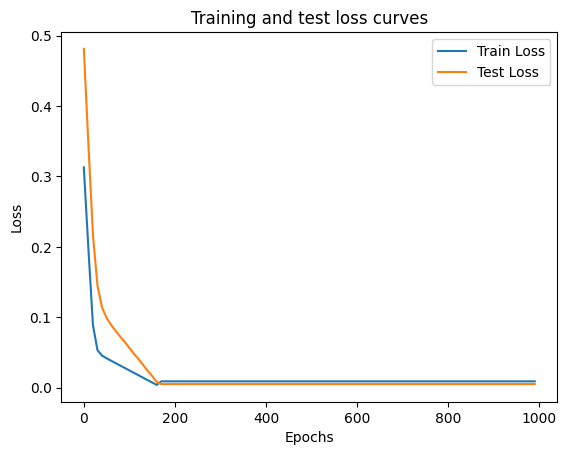

In [14]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [15]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

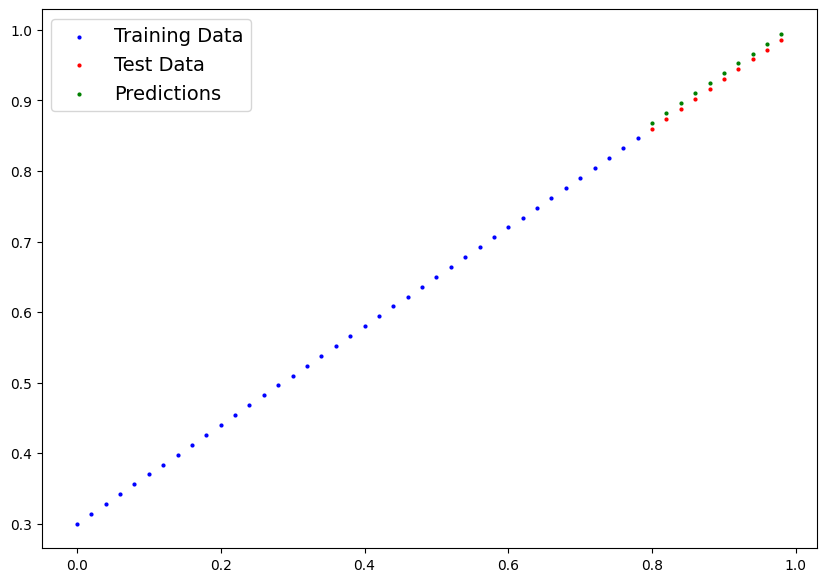

In [16]:
plot_predictions(predictions=y_preds_new)

## Saving Model in PyTorch

There are three main methods to save and load models

1. `torch.save()` - Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.
2. `torch.load()` - Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).
3. `torch.nn.Module.load_state_dict()` - Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

In [17]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth" # pth is pytorch file naming convention sometimes others uses .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model state_dict (recommended)
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [18]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Sep  1 12:18 01_pytorch_workflow_model_0.pth


## Loading a PyTorch Model

In [19]:
# To load a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-19-71edbbd0bd53>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [20]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [21]:
# Make some prediction with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [22]:
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

## Exercise (T4 Gpu)

In [7]:
# create *known* parameter
weight_exercise = 0.3
bias_exercise = 0.9

start_exercise = 0
end_exercise = 1
step_exercise = 0.01
# Note: X capital represent matrix or tensor, x lowercase represent vector
X_exercise = torch.arange(start_exercise, end_exercise, step_exercise).unsqueeze(dim=1)
y_exercise = weight_exercise * X_exercise + bias_exercise # Linear regression

len(X_exercise)

100

In [8]:
# Create a train/test split
train_split_exercise = int(0.8 * len(X_exercise)) # split 80%
X_train_exercise, y_train_exercise = X_exercise[:train_split_exercise].to("cuda"), y_exercise[:train_split_exercise].to("cuda")
X_test_exercise, y_test_exercise = X_exercise[train_split_exercise:].to("cuda"), y_exercise[train_split_exercise:].to("cuda")
X_test_exercise.device

device(type='cuda', index=0)

In [9]:
# Create linear regression model class
class LinearRegressionModelV2(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1, out_features=1) # size of input and size of output in this case size is 1

  # forward method to define the computation in the model
  # forward method adjust weight and bias to match our known parameter w=0.7, b=0.3
  # base class for all nn modules, if you subclass it, you should overwrite forward() (docs reference: torch.nn.Module forward() method)
  def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" is input data
    return self.linear_layer(x) # Linear regression

In [10]:
## Create random seed
torch.manual_seed(52)

# Create an instance of the model (this is a subclass of nn.Module)
model_0_exercise = LinearRegressionModelV2().to("cuda")
next(model_0_exercise.parameters()).device

device(type='cuda', index=0)

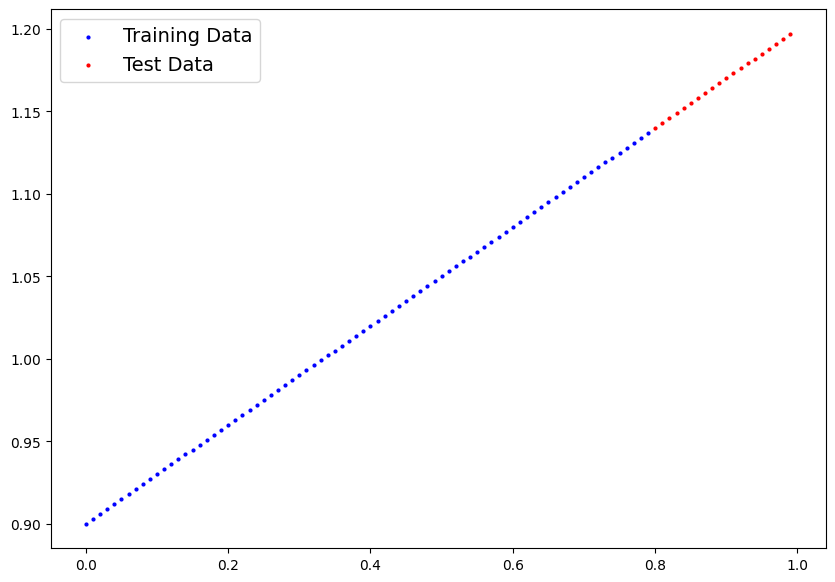

In [11]:
def plot_predictions_exercise(train_data=X_train_exercise.cpu(),
                     train_labels=y_train_exercise.cpu(),
                     test_data=X_test_exercise.cpu(),
                     test_labels=y_test_exercise.cpu(),
                     predictions=None):
  plt.figure(figsize=(10, 7))

  # plot data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

  # plot test data in red
  plt.scatter(test_data, test_labels, c="r", s=4, label="Test Data")

  if predictions is not None:
    # plot prediction if exist
    plt.scatter(test_data, predictions, c="g", s=4, label="Predictions")

  plt.legend(prop={"size": 14})

plot_predictions_exercise()

In [12]:
# Setup a loss function
loss_fn_exercise = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer_exercise = torch.optim.SGD(params=model_0_exercise.parameters(),
                            lr=0.01 # lr = learning rate = possibly the most important hyperparameter in ml
                            )

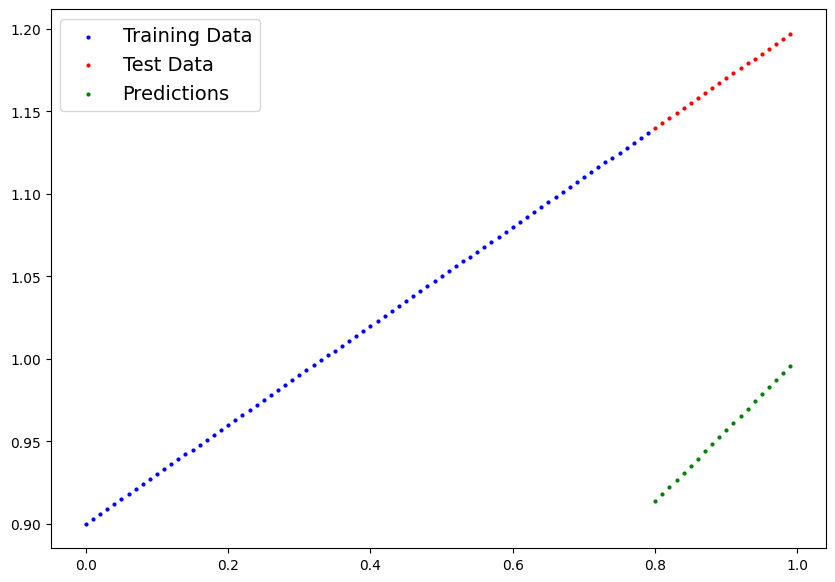

In [13]:
# context manager
with torch.inference_mode(): # inference mode turns off gradient tracking (similar to torch.no_grad(), but torch.inference_mode() i preferred)
  y_preds_exercise = model_0_exercise(X_test_exercise)

plot_predictions_exercise(predictions=y_preds_exercise.cpu())

In [14]:
torch.manual_seed(52) # optimizer step can be quite random depending on model prediction (y_pred_exercise)

# An epoch is one loop through the data (this is a hyperparameter)
epochs_exercise = 1000

# Track different values
epoch_count_exercise = []
loss_values_exercise = []
test_loss_values_exercise =[]


### Training (using training data)

#0. Loop through the data
for epoch in range(epochs_exercise):
  # Set the model to training mode
  model_0_exercise.train() # train mode in PyTorch sets all parameters that require gradients to require gradients


  #1. Forward propagation (also called forward pass)
  y_pred_exercise = model_0_exercise(X_train_exercise)

  #2. Calculate the loss (how wrong our model prediction is)(compare forward pass predictions to ground truth labels)(uses MAE)
  loss_exercise = loss_fn_exercise(y_pred_exercise, y_train_exercise)

  #3. Optimizer zero gradient
  optimizer_exercise.zero_grad() # start fresh each iteration

  #4. Backpropagation (Loss backward)
  loss_exercise.backward()

  #5. Optimizer step (Gradient descent)
  # Optimizer step optimize the parameter so that we can reach the point of convergence (where loss = 0 (great prediction))
  optimizer_exercise.step() # by default how optimizer changes will accumulate through the loop so we have to zero them above in step 3 for the next iteration of the loop
                  # may refer to the docs to understand why it accumulates

  ### Testing (using testing data)
  model_0_exercise.eval() # turns off different settings in the model not needing for testing
  with torch.inference_mode(): # turns off gradient tracking and couple more things behind the scenes
    #1. Forward propagation on test data
    test_pred = model_0_exercise(X_test_exercise)
    #2. Calculate the test loss (how wrong our model test prediction is)(compare forward pass predictions to ground truth labels)(uses MAE)
    test_loss_exercise = loss_fn_exercise(test_pred, y_test_exercise)
  if epoch % 20 == 0:
    epoch_count_exercise.append(epoch)
    loss_values_exercise.append(loss_exercise)
    test_loss_values_exercise.append(test_loss_exercise)
    print(f"Epoch: {epoch} | Loss: {loss_exercise} | Test loss: {test_loss_exercise}")
    print(model_0_exercise.state_dict())

Epoch: 0 | Loss: 0.2800804078578949 | Test loss: 0.2002982646226883
OrderedDict([('linear_layer.weight', tensor([[0.4364]], device='cuda:0')), ('linear_layer.bias', tensor([0.5776], device='cuda:0'))])
Epoch: 20 | Loss: 0.05903319641947746 | Test loss: 0.058357130736112595
OrderedDict([('linear_layer.weight', tensor([[0.5101]], device='cuda:0')), ('linear_layer.bias', tensor([0.7703], device='cuda:0'))])
Epoch: 40 | Loss: 0.038983430713415146 | Test loss: 0.08840872347354889
OrderedDict([('linear_layer.weight', tensor([[0.4914]], device='cuda:0')), ('linear_layer.bias', tensor([0.8171], device='cuda:0'))])
Epoch: 60 | Loss: 0.03210458531975746 | Test loss: 0.07380539178848267
OrderedDict([('linear_layer.weight', tensor([[0.4578]], device='cuda:0')), ('linear_layer.bias', tensor([0.8326], device='cuda:0'))])
Epoch: 80 | Loss: 0.025250453501939774 | Test loss: 0.058509666472673416
OrderedDict([('linear_layer.weight', tensor([[0.4239]], device='cuda:0')), ('linear_layer.bias', tensor([0.8

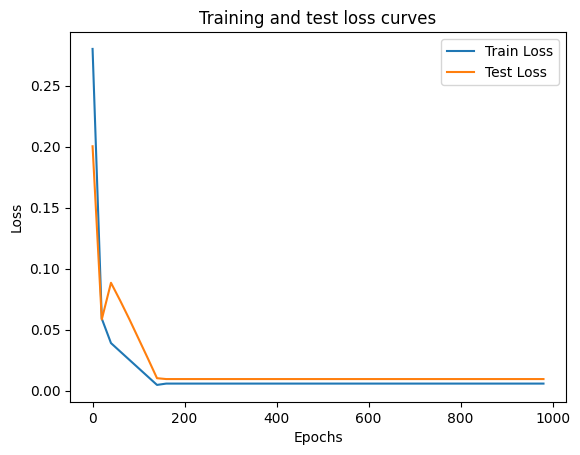

In [16]:
# Plot the loss curves
plt.plot(epoch_count_exercise, np.array(torch.tensor(loss_values_exercise).numpy()), label="Train Loss")
plt.plot(epoch_count_exercise, np.array(torch.tensor(test_loss_values_exercise).numpy()), label="Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

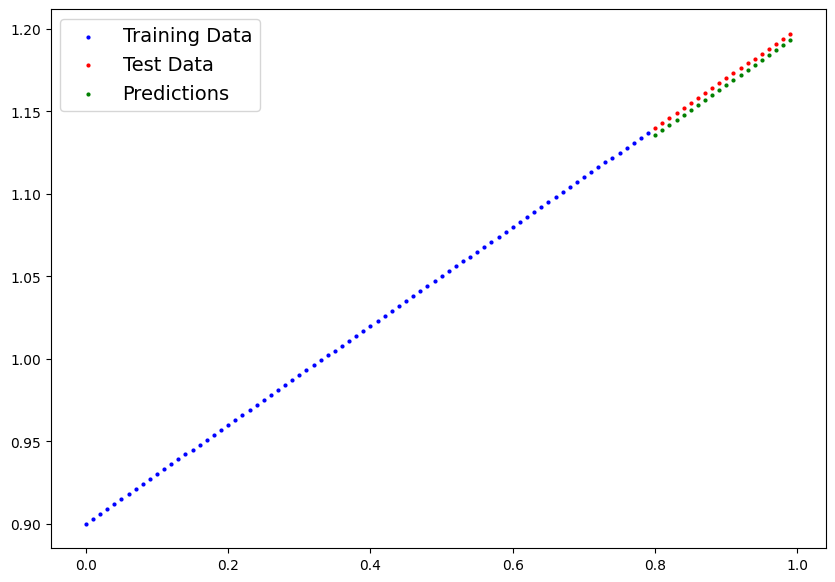

In [17]:
with torch.inference_mode(): # inference mode turns off gradient tracking (similar to torch.no_grad(), but torch.inference_mode() i preferred)
  y_preds_exercise_new = model_0_exercise(X_test_exercise)

plot_predictions_exercise(predictions=y_preds_exercise_new.cpu()) # matplotlib uses numpy, which run in the cpu

In [18]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0_exercise.pth" # pth is pytorch file naming convention sometimes others uses .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model state_dict (recommended)
torch.save(obj=model_0_exercise.state_dict(), f=MODEL_SAVE_PATH)

In [22]:
# To load a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0_exercise = LinearRegressionModelV2().to("cuda")

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0_exercise.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-22-514285d5db99>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0_exercise.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

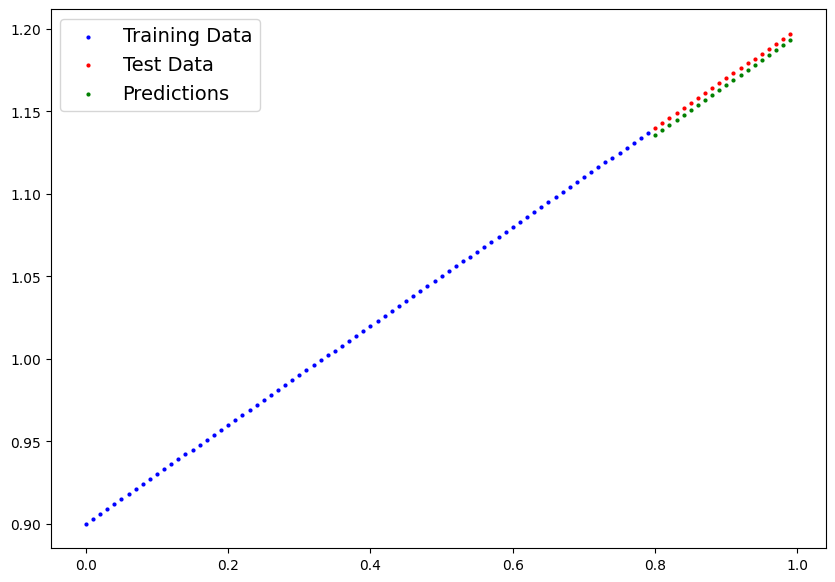

In [24]:
# Make some prediction with our loaded model
loaded_model_0_exercise.eval()
with torch.inference_mode():
  loaded_model_preds_exercise = loaded_model_0_exercise(X_test_exercise)

plot_predictions_exercise(predictions=loaded_model_preds_exercise.cpu())

In [25]:
model_0_exercise.eval()
with torch.inference_mode():
  y_preds_exercise = model_0_exercise(X_test_exercise)

loaded_model_preds_exercise == y_preds_exercise

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')